In [72]:
import numpy as np
import pandas as pd
from SALib.analyze import delta
from SALib.analyze import pawn
from SALib.util import read_param_file

In [73]:
# Read the parameter range file and generate samples
# Since this is "given data", the bounds in the parameter file will not be used
# but the columns are still expected
problem = read_param_file("../data/Ishigami.txt")
X = np.loadtxt("../data/model_input.txt")
Y = np.loadtxt("../data/model_output.txt")

In [74]:
# Perform the sensitivity analysis using the model output
# Specify which column of the output file to analyze (zero-indexed)
# Returns a dictionary with keys 'delta', 'delta_conf', 'S1', 'S1_conf'
Si = delta.analyze(
    problem, X, Y, num_resamples=10, conf_level=0.95, print_to_console=True
)

       delta  delta_conf        S1   S1_conf
x1  0.313063    0.023111  0.183910  0.061531
x2  0.154828    0.021756  0.092322  0.034706
x3  0.208364    0.043316  0.012630  0.042593


In [75]:
################################

In [76]:
# Champaign example
df = pd.read_csv("../data/champaign_ssp585_tasmax_soilM.csv")

In [159]:
df

,index,time,tasmax,model,ssp,method,soilMoist,soilMoistFrac,year
0,90,2030-04-01,17.452295,ACCESS-CM2,ssp585,LOCA2,66.350160,0.991211,2030
1,91,2030-04-02,22.542719,ACCESS-CM2,ssp585,LOCA2,66.938480,1.000000,2030
2,92,2030-04-03,20.697656,ACCESS-CM2,ssp585,LOCA2,66.938480,1.000000,2030
3,93,2030-04-04,19.958459,ACCESS-CM2,ssp585,LOCA2,66.938480,1.000000,2030
4,94,2030-04-05,11.775781,ACCESS-CM2,ssp585,LOCA2,66.938480,1.000000,2030
...,...,...,...,...,...,...,...,...,...
197635,394313,2059-09-26,20.241419,NorESM2-MM,ssp585,OKR_RegCM_Livneh,66.709045,0.364648,2059
197636,394314,2059-09-27,23.992615,NorESM2-MM,ssp585,OKR_RegCM_Livneh,82.597690,0.456352,2059
197637,394315,2059-09-28,24.090342,NorESM2-MM,ssp585,OKR_RegCM_Livneh,100.055510,0.553829,2059
197638,394316,2059-09-29,23.337286,NorESM2-MM,ssp585,OKR_RegCM_Livneh,101.118416,0.558993,2059


In [143]:
# Calculate metric
df_days = df.groupby(["year", "method", "model"]).apply(
    lambda x: ((x["soilMoistFrac"] <= 0.1) & (x["tasmax"] >= 29.0)).sum()).reset_index(name="days").groupby(["method","model"]).max().reset_index()

In [144]:
X,Y = df_days[["method", "model"]].to_numpy(), df_days["days"].to_numpy()

In [145]:
# Analyze
Si = delta.analyze(
    problem, X, Y, num_resamples=10, conf_level=0.95, print_to_console=True
)

           delta  delta_conf        S1   S1_conf
method  0.088171    0.051565  0.131423  0.172539
model   0.098516    0.058824  0.060068  0.215044


In [156]:
df_days.groupby("method")["days"].mean().var() / df_days["days"].var()

0.26526272140276036

In [158]:
df_days.groupby("model")["days"].mean().var() / df_days["days"].var()

0.6690160535513299

In [111]:
# Calculate metric
df_days = df.groupby(["year", "method", "model"]).apply(
    lambda x: ((x["soilMoistFrac"] <= 0.1) & (x["tasmax"] >= 29.0)).sum()).reset_index(name="days")

In [112]:
problem = {
    'num_vars': 2,
    'names': ['method', 'model'],
    'bounds': [[0, 0],
               [0, 0]]
}

df_out = pd.DataFrame(columns=["method", "model", "year"])

for year in df_days.year.unique():
    # Select year
    df_tmp = df_days[df_days.year == year].copy()
    # Get outputs
    Y = df_tmp["days"].to_numpy()
    X = df_tmp[["method", "model"]].to_numpy()
    # Analyze
    delta_df = delta.analyze(
        problem, X, Y, num_resamples=10, conf_level=0.95, print_to_console=False
    ).to_df()[["delta"]].T
    delta_df["year"] = year
    delta_df = delta_df.reset_index()[['method', 'model', 'year']].copy()
    # Append
    df_out = pd.concat([df_out, delta_df])

<AxesSubplot: xlabel='year'>

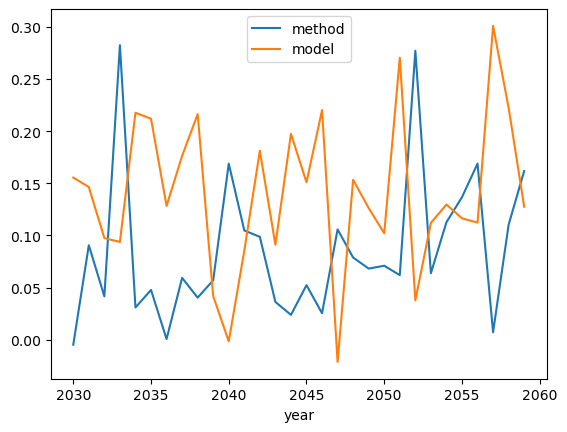

In [113]:
df_out.plot(x="year")